# 영화리뷰 텍스트 감성분석 하기

### 버전확인 및 데이터 불러오기

In [13]:
import pandas as pd
import konlpy
import gensim
import urllib.request
%matplotlib inline
import re
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

print(pd.__version__)
print(konlpy.__version__)
print(gensim.__version__)

1.3.3
0.5.2
4.1.2


In [14]:
# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


### 데이터 불러오기 함수 정의 및 데이터셋 분리 1

In [15]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 

### 단어와 인덱스 간의 전환과 인코딩/디코딩 함수 정의

In [16]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 

# 단어들을 하나씩 채워 봅니다. 채우는 순서는 일단 임의로 하였습니다. 그러나 사실 순서는 중요하지 않습니다. 
# <BOS>, <PAD>, <UNK>는 관례적으로 딕셔너리 맨 앞에 넣어줍니다. 

word_to_index["<PAD>"]=0
word_to_index["<BOS>"]=1
word_to_index["<UNK>"]=2
word_to_index["<UNUSED>"]=3

index_to_word={}
index_to_word = {index:word for word, index in word_to_index.items()}

index_to_word[0]='<PAD>'  # 패딩용 단어
index_to_word[1]='<BOS>'  # 문장의 시작지점
index_to_word[2]='<UNK>'# 사전에 없는(Unknown) 단어
index_to_word[3]='<UNUSED>'

def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [17]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


In [18]:
import tensorflow as tf

x_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre',
                                                        maxlen=maxlen)

x_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre', 
                                                       maxlen=maxlen)

print(x_train.shape)

(146182, 41)


## RNN(LSTM) Model

In [19]:
vocab_size = 1000  # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 15  # 단어 하나를 표현하는 임베딩 벡터의 차원수입니다. 

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 15)          15000     
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 768       
_________________________________________________________________
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 15,849
Trainable params: 15,849
Non-trainable params: 0
_________________________________________________________________


### 데이터셋 분리 2

In [20]:

x_val = x_train[:36000]   
y_val = y_train[:36000]

partial_x_train = x_train[110182:]  
partial_y_train = y_train[110182:]

print(x_val.shape)
print(partial_x_train.shape)

(36000, 41)
(36000, 41)


In [21]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
71/71 [==============================] - 24s 14ms/step - loss: 0.6788 - accuracy: 0.5743 - val_loss: 0.6356 - val_accuracy: 0.6699
Epoch 2/20
71/71 [==============================] - 1s 7ms/step - loss: 0.5659 - accuracy: 0.7640 - val_loss: 0.5208 - val_accuracy: 0.8027
Epoch 3/20
71/71 [==============================] - 1s 7ms/step - loss: 0.4955 - accuracy: 0.8051 - val_loss: 0.4725 - val_accuracy: 0.8098
Epoch 4/20
71/71 [==============================] - 1s 7ms/step - loss: 0.4484 - accuracy: 0.8124 - val_loss: 0.4381 - val_accuracy: 0.8104
Epoch 5/20
71/71 [==============================] - 1s 8ms/step - loss: 0.4237 - accuracy: 0.8160 - val_loss: 0.4226 - val_accuracy: 0.8121
Epoch 6/20
71/71 [==============================] - 1s 8ms/step - loss: 0.4084 - accuracy: 0.8204 - val_loss: 0.4156 - val_accuracy: 0.8116
Epoch 7/20
71/71 [==============================] - 1s 7ms/step - loss: 0.4015 - accuracy: 0.8206 - val_loss: 0.4100 - val_accuracy: 0.8137
Epoch 8/20
71/71 [

In [22]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


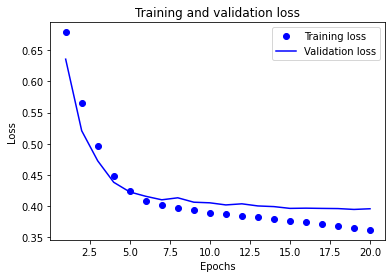

In [23]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

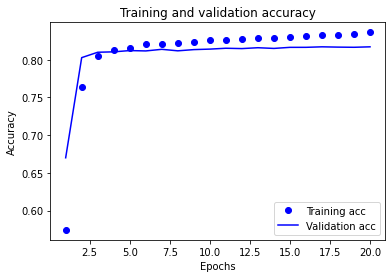

In [24]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## 1D-CNN Model

In [25]:
vocab_size = 1000  # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 15   # 단어 하나를 표현하는 임베딩 벡터의 차원 수입니다. 

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(5))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 15)          15000     
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          1696      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [26]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
71/71 [==============================] - 15s 10ms/step - loss: 0.6848 - accuracy: 0.5698 - val_loss: 0.6394 - val_accuracy: 0.7511
Epoch 2/20
71/71 [==============================] - 0s 7ms/step - loss: 0.5020 - accuracy: 0.7769 - val_loss: 0.4237 - val_accuracy: 0.8053
Epoch 3/20
71/71 [==============================] - 0s 6ms/step - loss: 0.4052 - accuracy: 0.8156 - val_loss: 0.4055 - val_accuracy: 0.8125
Epoch 4/20
71/71 [==============================] - 0s 7ms/step - loss: 0.3889 - accuracy: 0.8226 - val_loss: 0.4019 - val_accuracy: 0.8128
Epoch 5/20
71/71 [==============================] - 0s 6ms/step - loss: 0.3776 - accuracy: 0.8310 - val_loss: 0.3998 - val_accuracy: 0.8132
Epoch 6/20
71/71 [==============================] - 0s 6ms/step - loss: 0.3683 - accuracy: 0.8336 - val_loss: 0.3985 - val_accuracy: 0.8143
Epoch 7/20
71/71 [==============================] - 0s 6ms/step - loss: 0.3589 - accuracy: 0.8388 - val_loss: 0.3957 - val_accuracy: 0.8161
Epoch 8/20
71/71 [

In [27]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


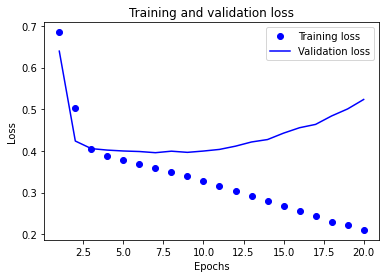

In [28]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

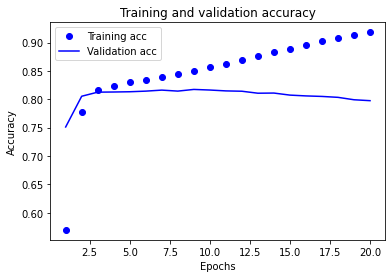

In [29]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## GlobalMaxPooling1D() Layer Only Model

In [30]:
vocab_size = 1000  # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 15   # 단어 하나를 표현하는 임베딩 벡터의 차원 수입니다. 

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 15)          15000     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 15)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 128       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 15,137
Trainable params: 15,137
Non-trainable params: 0
_________________________________________________________________


In [31]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
71/71 [==============================] - 1s 6ms/step - loss: 0.6808 - accuracy: 0.5796 - val_loss: 0.6560 - val_accuracy: 0.7067
Epoch 2/20
71/71 [==============================] - 0s 5ms/step - loss: 0.6143 - accuracy: 0.7419 - val_loss: 0.5677 - val_accuracy: 0.7639
Epoch 3/20
71/71 [==============================] - 0s 5ms/step - loss: 0.5292 - accuracy: 0.7861 - val_loss: 0.4960 - val_accuracy: 0.7862
Epoch 4/20
71/71 [==============================] - 0s 5ms/step - loss: 0.4690 - accuracy: 0.8035 - val_loss: 0.4543 - val_accuracy: 0.7969
Epoch 5/20
71/71 [==============================] - 0s 5ms/step - loss: 0.4334 - accuracy: 0.8116 - val_loss: 0.4321 - val_accuracy: 0.8014
Epoch 6/20
71/71 [==============================] - 0s 5ms/step - loss: 0.4127 - accuracy: 0.8180 - val_loss: 0.4213 - val_accuracy: 0.8043
Epoch 7/20
71/71 [==============================] - 0s 5ms/step - loss: 0.4003 - accuracy: 0.8212 - val_loss: 0.4158 - val_accuracy: 0.8063
Epoch 8/20
71/71 [==

In [32]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


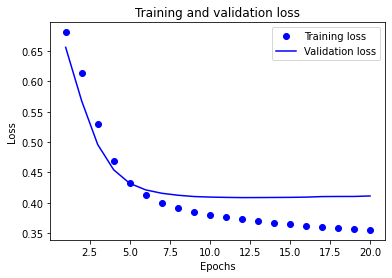

In [33]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

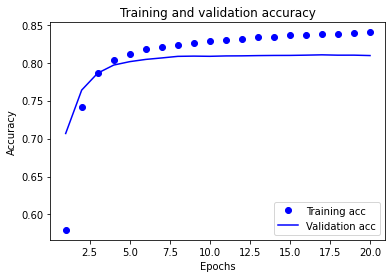

In [34]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## 모델 결과 비교 (표와 그래프)

| Model | loss | accuracy | val_loss | val_accuracy |
|:---|:---:|:---:|:---:|:---:|
| RNN(LSTM) | 0.3617 | 0.8364 | **0.3956** | **0.8170** |
| 1D-CNN | **0.2103** | **0.9181** | 0.5234 | 0.7975 |
|GlobalMaxPooling 1D()Layer Only | 0.3554 | 0.8401 | 0.4113 | 0.8094 |

,Model,Loss,Accuracy
RNN,RNN(LSTM),0.3617,0.8364
CNN,1D-CNN,0.2103,0.9181
GlobalMaxPooling,GlobalMaxPooling,0.3554,0.8401


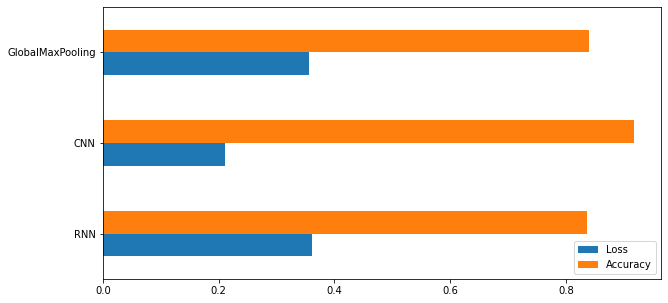

In [53]:
embedding_result_dict = {"Model":['RNN(LSTM)','1D-CNN','GlobalMaxPooling'],"Loss":[0.3617,0.2103,0.3554],
                        "Accuracy":[0.8364,0.9181,0.8401]}    
embedding_result_df = pd.DataFrame(embedding_result_dict, index=['RNN', 'CNN', 'GlobalMaxPooling'])
embedding_result_df.plot.barh(figsize=(10,5))
embedding_result_df

In [35]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(1000, 15)


## 영어 임베딩

In [36]:
import os
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [37]:
from gensim.test.utils import lee_corpus_list
from gensim.models import Word2Vec
model = Word2Vec(lee_corpus_list, vector_size=15, epochs=71)
word_vectors = model.wv

In [38]:
from gensim.models import KeyedVectors
word_vectors.save('vectors.kv')
reloaded_word_vectors = KeyedVectors.load('vectors.kv')

In [39]:
import gensim.downloader as api
word_vectors = api.load("glove-wiki-gigaword-100")  # load pre-trained word-vectors from gensim-data
# Check the "most similar words", using the default "cosine similarity" measure.
result = word_vectors.most_similar(positive=['woman','king'], negative=['man'])
most_similar_key, similarity = result[0]  # look at the first match
print(f"{most_similar_key}: {similarity:.4f}")

[==================================================] 100.0% 128.1/128.1MB downloaded
queen: 0.7699


## 한국어 임베딩

In [40]:
from gensim.models import KeyedVectors

word2vec_path = os.getenv('HOME')+'/data/word2vec_ko.model'
word_vectors = KeyedVectors.load(word2vec_path)
vector = word_vectors.wv['끝']

import tempfile

with tempfile.NamedTemporaryFile(prefix='gensim-model-', delete=False) as tmp:
    temporary_filepath = tmp.name
    model.save(temporary_filepath)   

In [41]:
from gensim.models.keyedvectors import Word2VecKeyedVectors
word_vectors = Word2VecKeyedVectors.load(word2vec_path)

from numpy import dot
from numpy.linalg import norm
import numpy as np

vector_1 = word_vectors.wv['사랑']
vector_2 = word_vectors.wv['행복']
vector_3 = word_vectors.wv['끝']

def cos_sim(A, B):
    return dot(A, B)/(norm(A)*norm(B))
  
print('{}과 {}의 코사인 유사도 : {}'.format('사랑','행복',cos_sim(vector_1,vector_2)))
print('{}과 {}의 코사인 유사도 : {}'.format('사랑','끝',cos_sim(vector_1,vector_3)))

사랑과 행복의 코사인 유사도 : 0.7550067901611328
사랑과 끝의 코사인 유사도 : 0.1875794529914856


In [42]:
import gensim 
from gensim.models import KeyedVectors
word2vec_path = os.getenv('HOME')+'/data/word2vec_ko.model'
word2vec = gensim.models.Word2Vec.load(word2vec_path)
result = word2vec.wv.most_similar("고양이") 
most_similar_key, similarity = result[0]  
print(f"{most_similar_key}: {similarity:.4f}")

토끼: 0.8526


## word2vec을 이용한 모델 성능 향상 훈련

In [43]:
from tensorflow.keras.initializers import Constant

voca_size = 10000
word_vec_dim = 100
embedding_matrix = np.random.rand(voca_size, word_vec_dim)

for i in range(4,voca_size):
    if index_to_word[i] in word2vec.wv :
        embedding_matrix[i] = word2vec.wv[index_to_word[i]]

In [49]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(voca_size, word_vec_dim, embeddings_initializer = Constant(embedding_matrix),
                                   input_length = maxlen, trainable = True))
model.add(tf.keras.layers.LSTM(8))   
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid')) 

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 41, 100)           1000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 8)                 3488      
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 9         
Total params: 1,003,569
Trainable params: 1,003,569
Non-trainable params: 0
_________________________________________________________________


In [50]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
epochs = 15
model_history = model.fit(partial_x_train, partial_y_train, epochs = epochs, batch_size=64, validation_data=(x_val,y_val),
                         verbose=1)

Epoch 1/15
563/563 [==============================] - 6s 8ms/step - loss: 0.5996 - accuracy: 0.6694 - val_loss: 0.4993 - val_accuracy: 0.7629
Epoch 2/15
563/563 [==============================] - 4s 7ms/step - loss: 0.4449 - accuracy: 0.7973 - val_loss: 0.4270 - val_accuracy: 0.8087
Epoch 3/15
563/563 [==============================] - 4s 7ms/step - loss: 0.3752 - accuracy: 0.8375 - val_loss: 0.4103 - val_accuracy: 0.8193
Epoch 4/15
563/563 [==============================] - 4s 7ms/step - loss: 0.3311 - accuracy: 0.8606 - val_loss: 0.3993 - val_accuracy: 0.8237
Epoch 5/15
563/563 [==============================] - 4s 7ms/step - loss: 0.2976 - accuracy: 0.8776 - val_loss: 0.4033 - val_accuracy: 0.8268
Epoch 6/15
563/563 [==============================] - 4s 7ms/step - loss: 0.2712 - accuracy: 0.8896 - val_loss: 0.4100 - val_accuracy: 0.8268
Epoch 7/15
563/563 [==============================] - 4s 7ms/step - loss: 0.2497 - accuracy: 0.8993 - val_loss: 0.4208 - val_accuracy: 0.8284
Epoch 

<회고>

NLP로 입문하는 기분이 들었습니다. 신경망이 자연어 처리에도 쓰일 수 있음을 알고 신기했지만  
실제로 어떤 원리로 동작하는지 알려면 더 공부를 해봐야겠네요. 

* 3가지 모델에 대해서 4가지 지표를 얻어 표로 정리했는데 한 모델이 4가지 지표 모두 우수한 경우는 없었습니다.
* validation set에 대한 성능은 LSTM을 이용한 RNN이 나았지만 training set에 대한 성능은 1D-CNN이 더 좋았네요.
* 그래프로 정리를 하니 그나마 1D-CNN의 낮은 Loss와 높은 Accuracy가 눈에 보였습니다.

그리고 gensim을 이용하여 한국어 임베딩을 이용해 봤습니다. 

* 역시 예상대로 '사랑'과 '행복'은 코사인 유사도가 높게 나왔고 
* '사랑'과 '끝'은 낮게 나왔네요. 
* 적절히 학습됐나봅니다.
* 고양이만큼 토끼가 귀여운지는 잘 모르겠네요. 주관에 맡기겠습니다.

마지막으로 word2vec을 이용한 성능 향상을 측정해 보았습니다. 모델은 RNN (LSTM)으로 하였고  
에폭은 15로 하였습니다. 그 결과 Accuracy가 **94.98%** 가 나왔습니다.